In [1]:
#primero importamos las librerías que usaremos

import numpy as np
import scipy as sc #expande las opciones de numpy
import matplotlib.pyplot as plt# librería para la visualización de los datos
from sklearn.datasets import make_circles#librería y función para simular un “data set” de puntos en un plano

%matplotlib inline 
#esta línea ayuda a no tener que usar plt.show() mostrando todo dentro del mismo grafico
#pero en algunos casos lo usaremos de todas maneras para separar las visualizaciones 

In [2]:
make_circles?
#para entender cómo funciona se le pone el signo de "?" y se mostrara una ventana con la documentación de esta función
#es como el comando help

(500,)
(500, 1)


(-1.312593484251369, 1.322396644067572, -1.4009168621003256, 1.250792145779416)

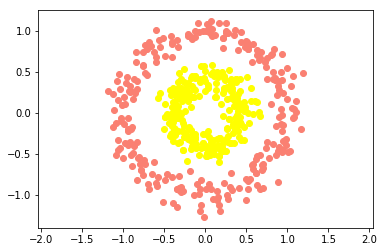

In [3]:
# crear data set o la base de datos que usaremos para probar la red neuronal y luego los datos de ejemplo 

n = 500 #número de registros 

#por ejemplo la cantidad de personas registradas en nuestro data set

p =  2  #cuantas características tiene cada registro

#por ejemplo edad y altura de una persona (estas son las entradas de la primera capa en este ejemplo)
#usamos 2 únicamente porque es más fácil de visualizar los datos, pero en general se usarían más características

#imitamos un data set a través de la función make_circules
x, y = make_circles(n_samples=n, factor=0.4, noise=0.1)
#siendo n_samples el número de ejemplos que tendrá
#fator el factor la distancia entre el primero y el segundo circulo
#noise el ruido o datos erráticos en el data set y así agregar dificultad al problema

#aqui le agregamos una nueva dimencion a y
print(y.shape)
y=y[:,np.newaxis]
print(y.shape)

#y cambiamos su forma de (500,0) a (500,1)

#aqui visualizamos los datos de los circulos en el gráfico 
plt.scatter(x[y[:,0] ==0,0],x[y[:,0] == 0,1], c="salmon")#primer conjunto en color salmón
plt.scatter(x[y[:,0] ==1,0],x[y[:,0] == 1,1], c="yellow")#segundo conjunto en color amarillo
plt.axis("equal") #hace que se muestren en proporciones iguales a los ejes y así se vea más cómodo a la vista
#NOTA:[:,0] es todos los puntos

función Sigmoidea y su derivada


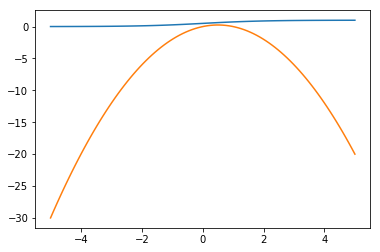

función Tangente hiperbolica y su derivada


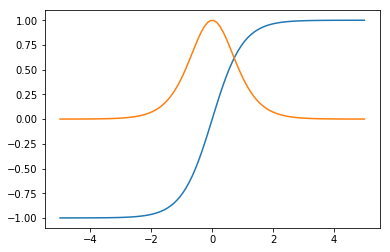

función Rectificadora lineal unificada


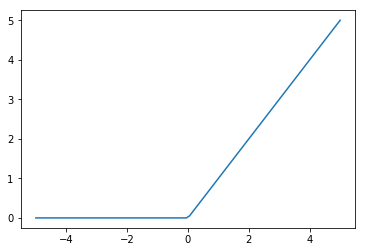

In [4]:
# funciones de activación

#las funciones de activación son la esencia y núcleo de cada neurona
#es el proceso que transforma los datos de entrada en pesos y conexiones a las demás neuronas 
#y permite una interpretación de los datos de manera no lineal

#escribiré varias para poder usar una o 2 de ejemplo

sigm = (lambda x: 1/(1+np.e **(-x)), #esta es la funcion sigmoide
        lambda x: x * (1-x)) #esta es la derivada de la funcion sigmoide

relu = lambda x: np.maximum(0,x)

sinh = lambda x: ((np.e ** x)-(np.e **-x))/2

cosh = lambda x: ((np.e ** x)+(np.e **-x))/2

sech = lambda x: (1/cosh(x))

coth = (lambda x: ((np.e**x)+(np.e**-x))/((np.e**x)-(np.e**-x)),
       lambda x: (cosh(x))**2)
#coth = lambda x: (cosh(x)/sinh(x))


tanh = (lambda x: ((np.e**x)-(np.e**-x))/((np.e**x)+(np.e**-x)),
        lambda x: (1/(cosh(x))**2))

expo = (lambda x: (x)**2,
      lambda x: 2*x )
        
_x = np.linspace(-5,5,100)

print("función Sigmoidea y su derivada")
#usaremos la derivada para cuando ajustemos los pesos de manera jerarquizada, a través del método backpropagation
plt.plot(_x,sigm[0](_x))
plt.plot(_x,sigm[1](_x))
plt.show()

print("función Tangente hiperbolica y su derivada")
plt.plot(_x,tanh[0](_x))
plt.plot(_x,tanh[1](_x))
plt.show()

print("función Rectificadora lineal unificada")
plt.plot(_x,relu(_x))
plt.show()

In [5]:
#el objeto capa o neural_layer es aquel que contiene un cierto número de neuronas haciendo una función en especifico
#esta contiene arreglos con las neuronas sus pesos 
#y sus conexiones a otras neuronas en las capas anteriores o posteriores
class neural_layer():
    def __init__(self,n_conn,n_neur,act_f):
        #n_conn es el número de conexiones
        #n_neur es el número de neuronas 
        #act_f es la función de activación de la capa
        
        #asignamos los valores a las variables
        self.act_f = act_f
        
        self.b = np.random.rand(1,n_neur) * 2 - 1
        # b es el parámetro de "bias" que primero me da un numero entre -1 y 1 (aunque esto puede variar) 
        #y tendremos tantos como neuronas hay en la capa 
        #este es el umbral de activación que debe alcanzar la neurona para activarse
        
        #ya que random da un numero entre 0 y 1 de manera aleatoria, entonces los multiplicamos por 2 y le restamos 1 
        #para que el valor vaya desde -1 a 1
        
        # w viene siendo el peso de la neurona y tambien lo iniciaremos entre -1 y 1 
        self.w = np.random.rand(n_conn,n_neur) * 2 - 1

In [6]:
#podemos ir creando cada capa por separado de esta forma
#l0 = neural_layer(p,4,sigm)
#l1 = neural_layer(4,8,sigm)
#	.
#	.
#	.
#hasta la capa final 
#ln = neural_layer(4,1,sigm)
#y luego agregarlas a un objeto neural_net = []
#neural_net.append(l0,l1,l2...,ln); 

#pero al ser un proceso repetitivo podemos automatizarlo 
#por lo que crearemos una función que se encargue de crear e indexar 
#las capas y así optimizar el proceso, al menos para efectos prácticos de este ejemplo
#podría llegar a ser necesario usar arquitecturas con distintas conexiones y funciones dentro de algunas capas

#primero definimos la función y le decimos los parámetros que necesitaremos
def create_nn(topology, act_f):
#topology será la topología que usaremos en la red por ejemplo 2 neuronas en la capa de entrada 4 en la primera oculta
#y así hasta la capa de salida

#act_f la función de activacion q ocuparemos en las capas    

    nn = []#arreglo que contendrá a todas las capas de la red neuronal    
    
    #este ciclo agrega una capa al arreglo según la topología estipulada anteriormente 
    for l , layer in enumerate(topology[:-1]):
        #añadimos una capa con un número de conexiones igual a “topology” 
        #en la posición “l” hasta el último valor del arreglo
        nn.append(neural_layer(topology[l],topology[l+1],act_f))
        
    return nn


topology =[p,4,4,1] #numero de neuronas por capa la primera capa tiene p entradas, luego 4 y asi hasta la capa de salida

#
neural_net = create_nn(topology,tanh)

neural_net

In [7]:
#función para entrenar la red neuronal
l2_coste = (lambda Yp,Yr: np.mean((Yp - Yr)**2),
           lambda Yp,Yr: (Yp-Yr))

#esta nos dará algo así como los márgenes de error

#el entrenamiento de la red se divide en 2 partes
#primero un paso hacia adelante y uno hacia atrás que reajusta los pesos de las neuronas

#primero definimos la función entrenar o train

def train(neural_net,x,y,l2_coste,lr=0.5,training=True):
    out = [(None,x)]
    #forward pass o propagación hacia adelante
    for l, layer in enumerate(neural_net):
        #por cada capa se aplica un proceso de sumatoria de los datos de entradas
        z = out[-1][1] @ neural_net[l].w + neural_net[l].b #suma ponderada de las entradas, @ es para multiplicar matricialmente
        
        # y luego son procesadas por una función de activación que le da una NO linealidad a los datos
        a = neural_net[l].act_f[0](z)
        
        out.append((z,a))
    
    print(l2_coste[0](out[-1][1],y))
    
    if training:
        #backward pass, backpropagation o propagación hacia atrás
        deltas = [] #deltas es el arreglo que guarda todas las derivadas parciales según la capa anterior
        #esto permite saber la gradiente y asi podemos calcular su inversa
        for l in reversed (range(0,len(neural_net))):
            z = out[l+1][0]
            a = out[l+1][1]
            #calcular delta ultima capa 
            if l == len(neural_net)-1:
                deltas.insert(0,l2_coste[1](a,y)* neural_net[l].act_f[1](a))#insertar al principio porque vamos de atras para adelante
            else:
                deltas.insert(0,deltas[0]@ _w.T * neural_net[l].act_f[1](a))
            _w = neural_net[l].w
            #gradient descent
            #actualizamos el "bias" de cada neurona
            neural_net[l].b = neural_net[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr
            #actualizamos los pesos de cada neurona
            neural_net[l].w = neural_net[l].w - out[l][1].T @ deltas[0] * lr
    return out[-1][1]
train(neural_net,x,y,l2_coste,0.5)

0.28166437406482625


array([[0.75038083],
       [0.8349833 ],
       [0.61717577],
       [0.77925144],
       [0.86196483],
       [0.31492881],
       [0.73069466],
       [0.74460863],
       [0.65098564],
       [0.39014198],
       [0.69009867],
       [0.91338628],
       [0.86788552],
       [0.69656982],
       [0.91908794],
       [0.84444088],
       [0.73842957],
       [0.84194324],
       [0.69917574],
       [0.60810443],
       [0.86742949],
       [0.43458587],
       [0.8872085 ],
       [0.81342351],
       [0.8285108 ],
       [0.68214706],
       [0.33853975],
       [0.73282928],
       [0.5898857 ],
       [0.894288  ],
       [0.56667677],
       [0.71956601],
       [0.46708505],
       [0.61912332],
       [0.60718659],
       [0.83682373],
       [0.74292375],
       [0.40594077],
       [0.90640148],
       [0.78347217],
       [0.87043183],
       [0.83465267],
       [0.66497465],
       [0.59299475],
       [0.90165811],
       [0.20476791],
       [0.80384079],
       [0.725

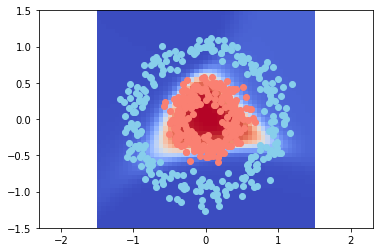

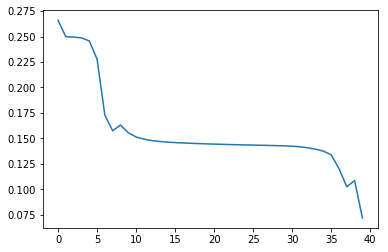

0.06953733955753938
0.06456437996216957
0.062211844404356065
0.056367044868255875
0.05572852481139532
0.049721440940177074
0.05235894219946978
0.046546039533801646
0.052885763424163006
0.04628656047744823
0.05611519937805934
0.04692145793615707
0.05884678339039809
0.04663975947779668
0.058578529557552085
0.045423014778607114
0.056365589434205304
0.04421705617478074
0.05450352365497734
0.043629591089576834
0.0539260847793894
0.04364698398464493
0.05419446319572671
0.043961495367319345


In [8]:
import time
from IPython.display import clear_output

neural_n = create_nn(topology,sigm)
loss = []

for l in range(1000):
    pY = train(neural_n,x,y,l2_coste,lr=0.07)#lr=0.07 para cuando uso sigmoide y 0.001 si uso tanh o me dara valores nan 
    #usar valores cercanos a estos o no funcionara
    if l % 25 == 0:
        loss.append(l2_coste[0](pY,y))
        res = 50
        _x0 = np.linspace(-1.5,1.5,res)
        _x1 = np.linspace(-1.5,1.5,res)
        
        _y = np.zeros((res,res))
        
        for l0,x0 in enumerate(_x0):
            for l1,x1 in enumerate(_x1):
                _y[l0,l1] = train(neural_n,np.array([[x0,x1]]),y,l2_coste,training=False)[0][0]
        plt.pcolormesh(_x0,_x1,_y,cmap="coolwarm")
        plt.axis("equal")
        
        plt.scatter(x[y[:,0]==0,0], x[y[:,0]==0,1],c="skyblue")
        plt.scatter(x[y[:,0]==1,0], x[y[:,0]==1,1],c="salmon")
       
        clear_output(wait=True)
        
        plt.show()
        plt.plot(range(len(loss)),loss)
        plt.show()
        time.sleep(0.5)

In [ ]:
#y esto es un ejemplo de codigo implementando redes neuranales con backpropagation 